# Monte Carlo simulation

In [60]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math
from itertools import permutations
from itertools import product

In [3]:
import datetime
import pandas_datareader as pdr
import datetime
import yfinance as yf
%matplotlib inline

## Show historical TSLA stock price

In [4]:
start_date=datetime.datetime(2017,11,28)
end_date=datetime.datetime(2023,11,28)
tickers = 'TSLA'
prices = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
historical = prices['Adj Close'].dropna(how='all')
historical

Date
2017-11-28     21.170000
2017-11-29     20.502666
2017-11-30     20.590000
2017-12-01     20.435333
2017-12-04     20.346666
                 ...    
2023-11-20    235.600006
2023-11-21    241.199997
2023-11-22    234.210007
2023-11-24    235.449997
2023-11-27    236.080002
Name: Adj Close, Length: 1509, dtype: float64

In [6]:
ret = historical.pct_change()[1:] #daily returns for the month
ret

Date
2017-11-29   -0.031523
2017-11-30    0.004260
2017-12-01   -0.007512
2017-12-04   -0.004339
2017-12-05   -0.004915
                ...   
2023-11-20    0.005548
2023-11-21    0.023769
2023-11-22   -0.028980
2023-11-24    0.005294
2023-11-27    0.002676
Name: Adj Close, Length: 1508, dtype: float64

In [7]:
days = len(ret)
sample_mean_tsla = np.mean(ret)
sample_std_tsla = np.std(ret, ddof=1)

sample_mean_tsla,sample_std_tsla

(0.0024043663221886644, 0.040156388904390154)

In [8]:
sample_variance_tsla=sample_std_tsla**2
sample_variance_tsla

0.0016125355698406287

In [9]:
lastPrice= S0 = historical.iloc[-1]
S0

236.0800018310547

## European Option

### Monte Carlo Simulation

In [10]:
def monte_carlo_option_price(S, K, r, T, vol, num_simulations,opttype='call'):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days )
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        simulated_prices[i, :] = price_path

    if opttype.lower() == 'call':
        
        option_payoffs = np.maximum(simulated_prices[:, -1] - K, 0)  # Payoff for call option at expiration
    elif opptype.lower() == 'put':
    
        option_payoffs = np.maximum(K - simulated_prices[:, -1], 0)  # Payoff for put option at expiration
    else:
        raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")
    option_price = np.exp(-r * T) * np.mean(option_payoffs)

    return option_price, simulated_prices

In [11]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations

#potremmo definire diversamente il tempo, per esempio possiamo valutare sempre opzioni di un anno e dividere il numero di giorni per il numero di step in cui puoi ricattare l'opzione

In [12]:
# European Call Option Price with Monte Carlo Simulation
option_price, price_paths = monte_carlo_option_price(S, K, r, T, vol, num_simulations,'call')

# Stampa del prezzo dell'opzione e visualizzazione dei path
print("Prezzo dell'opzione:", option_price)



Prezzo dell'opzione: 0.6059621392343038


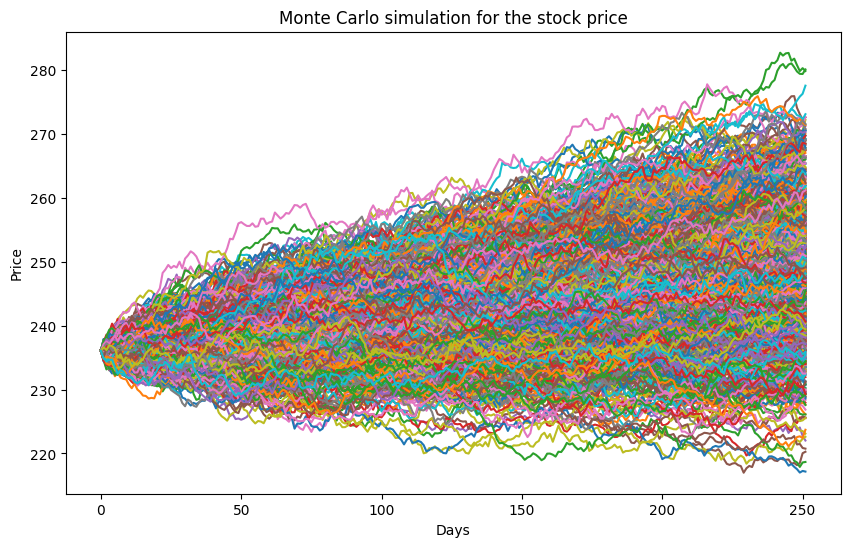

In [13]:
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(price_paths[i, :], label=f'Simulazione {i + 1}')

plt.title('Monte Carlo simulation for the stock price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

### Binary tree


In [14]:
N=36# numero di passi nel periodo prestabilito
T=1
S = S0
dt=T/N
K = 260
r = 0.05045
u = np.exp(sample_std_tsla * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
d = 1/u

In [15]:
def binomial_tree_european(K,T,S0,r,N,vol,opttype='call'):
    #precompute constants
    dt = T/N
    u = np.exp(vol * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
    d = 1/u
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N #you are taking the worst scenario 
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d  # you're doing like a zig zag at time T to obtain all the prices

    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype.lower() == 'put':
            C[j] = max(0, K - S[j])
        elif opttype.lower()=='call':
            C[j] = max(0, S[j] - K)
        else:
            raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

       
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )

    return C[0]

binomial_tree_european(K,T,S,r,N,vol,'call')

0.5318703931520848

## American Option


### Monte Carlo

In [16]:
def monte_carlo_american_option(S, K, r, T, vol, n_simulations ,opttype='call'):# da capire bene
    dt = 1/ 252
    num_days=int(T*252)
    option_price = 0
    
    for i in range(n_simulations):
        stock_price = S
        for j in range(num_days):
            # Generate random normal variables for stock price movement
            Z = np.random.normal(0, 1)
            stock_price *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            
            # Calculate the option payoff
            payoff = max(stock_price - K, 0)
            
            # Check for early exercise
            intrinsic = max(stock_price - K, 0)
            option_price = max(option_price, intrinsic)
        
        option_price += payoff
    
    option_price /= n_simulations
    discounted_price = option_price * np.exp(-r * T)
    
    return discounted_price

# Example usage
S = S0  # Current stock price
K = 260  # Option strike price
r = 0.05045  # Risk-free interest rate
sigma = sample_std_tsla # Volatility
T = 1  # Time to expiration
n_simulations = 1000  # Number of simulations
n_steps = 100  # Number of steps in the simulation

# Calculate option price using Monte Carlo simulation
option_price_monte_carlo = monte_carlo_american_option(S, K, r, sigma, T, n_simulations, n_steps)
print(f"American Option Price using Monte Carlo simulation: ${option_price_monte_carlo:.2f}")

American Option Price using Monte Carlo simulation: $0.00


In [17]:
#Price is lower here because you have more 0, more days with no payoff, so the average is affected. 
#If you are a smart trader, you will have a strategy to exit at a good time
#We assume that the trader will not exercice the option when the value is 0, but only when he has a payoff

def monte_carlo_american_option_price(S, K, r, T, vol, num_simulations, option_type='call'):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration
    discount_factors = np.exp(-r * np.arange(num_days) * dt)  # Discount factors for each day

    simulated_prices = np.zeros((num_simulations, num_days))
    option_values = np.zeros((num_simulations, num_days))  # Store option values at each step

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
            
        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Calculate option intrinsic values at each step (consider all steps for American option)
        if option_type.lower() == 'call':
            option_values[i, :] = np.maximum(price_path - K, 0)  # Call option payoff for each day
        elif option_type.lower() == 'put':
            option_values[i, :] = np.maximum(K - price_path, 0)  # Put option payoff for each day

    # Discount the option values to present value
    discounted_option_values = option_values * discount_factors

    # Filter out non-positive payoffs and flatten the array
    positive_discounted_payoffs = discounted_option_values[discounted_option_values > 0]

    # Calculate the average of the positive payoffs
    
    option_price = np.mean(positive_discounted_payoffs)

    return option_price, simulated_prices


#----------

K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations

#----------

# Call the function with 'call' as a string
option_price, price_paths = monte_carlo_american_option_price(S0, K, r, T, vol, num_simulations, 'call')
print("American Option Price:", option_price)

American Option Price: 4.2583847777118375


### Binary Tree

In [18]:
def american_tree(S0,K,T,r,N,vol,opttype='call'):
    #precompute values
    dt = T/N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # initialise stock prices at maturity
    S = np.zeros(N+1)
    for j in range(0, N+1):
        S[j] = S0 * u**j * d**(N-j)

    # option payoff
    C = np.zeros(N+1)
    for j in range(0, N+1):
        if opttype.lower() == 'put':
            C[j] = max(0, K - S[j])
        elif opttype.lower()=='call':
            C[j] = max(0, S[j] - K)
        else:
            raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")


    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * u**j * d**(i-j)
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
            if opttype.lower() == 'put':
                C[j] = max(C[j], K - S)
            else:
                C[j] = max(C[j], S - K)

    return C[0]

american_tree(S0,K,T,r,252,vol,opttype='call')  

0.5940902494287987

Problema con l'opzione americana -> più è grande N e più alto risulta il prezzo dell'opzione.
L'opzione americana può essere riscattata in qualsiasi momento quindi ha una finestra temporale pressocchè infinita. Come gestiamo sta cosa?


## American Digital Option


L'american digital option funziona che ha un pagamento fisso ad una data prefissata, questo pagamento avviene se il prezzo del sottostante asset soddisfa un certo criterio (per esempio se raggiunge un certo prezzo). Non deve soddisfarlo alla scadenza, basat che nella durata dell'opzione almeno una volta l'abbia soddisfatto.


Come procederei? attraverso il metodo di montecarlo ricreando il moto browniano del prezzo dell'opzione sceglierei un livello di prezzo K, si conta il nunero di simulazioni che hanno soddisfatto questo requisito e si calcola il payout medio che si sconterà e dovrà essere uguae al tasso risk free.

## Montecarlo method

In [19]:
def monte_carlo_digital_option_price(S, K, r, T, vol, win, num_simulations):
    dt = 1 / 252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        # Check the condition for payment and set the simulated prices accordingly
        if (S <= K and np.max(price_path) >= K) or (S > K and np.min(price_path) < K):
            simulated_prices[i] = win
        else:
            simulated_prices[i] = 0

    option_price = np.exp(-r * T) * np.mean(simulated_prices)
    return option_price


In [20]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
win=1
vol = sample_std_tsla  # Volatility
num_simulations = 10000 # Number of Monte Carlo simulations

In [31]:
print("Prezzo dell'opzione:", monte_carlo_digital_option_price(S, K, r, T, vol,win, num_simulations))

Prezzo dell'opzione: 0.7060045364465317


## Binary tree

In [32]:
def american_digital_tree(S, barrier, r, vol, T=1,win=1, N=10):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = []
    for i in range(N + 1):
        path = np.concatenate((np.zeros(i), np.ones(N - i)))
        paths.extend(set(permutations(path)))

    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 1:  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)
        if S < barrier:
            # Opzione digitale americana: paga 1 se il massimo dei prezzi supera la barriera, altrimenti paga 0
            payoff = win if max(prices) < barrier else 0
        else:
            payoff = win if min(prices) > barrier else 0

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price

print("Prezzo dell'opzione:",american_digital_tree(S, K, r, vol,T, 1, 10))

Prezzo dell'opzione: 0.4295281898371117


## Knock Out Option

* A knock-out option is a type of barrier option. Barrier options are typically classified as either knock-out or knock-in.
* A knock-out option ceases to exist if the underlying asset reaches a predetermined barrier during its life.
* The two types of knock-out options are up-and-out barrier options and down-and-out options.
* Knock-out options limit losses, but also potential profits.-

A down-and-out option is one variety. It gives the holder the right, but not the obligation, to purchase or sell an underlying asset at a predetermined strike price—if the underlying asset's price does not go below a specified barrier during the option's life. Should the underlying asset's price fall below the barrier at any point in the option's life, the option expires worthless.

For example, assume an investor purchases a down-and-out call option on a stock that is trading at $60, with a strike price of $55 and a barrier of $50. If the stock trades below $50, at any time, before the call option expires then the down-and-out call option promptly ceases to exist. 



Contrary to a down-and-out barrier option, an up-and-out barrier option gives the holder the right to buy or sell an underlying asset at a specified strike price if the asset has not exceeded a specified barrier during the option's life. An up-and-out option is only knocked out if the price of the underlying asset moves above the barrier.

Assume an investor purchases an up-and-out put option on a stock trading at $40, with a strike price of $30 and a barrier of $45. Over the life of the option, the stock hits a high of $46 but then drops to $20 per share. Too bad: the option still would automatically expire because the barrier of $45 had been breached. Now, if the stock hadn't gone above $45 and eventually sold off to $20, then the option would remain in place and have value to the holder.

### Montecarlo Simulation


In [23]:
# Initialise parameters
K = 220     # strike price
T = 1         # time to maturity in years
B = 250     # up-and-out barrier price/value
r = 0.01      # annual risk-free rate
vol = 0.2     # volatility (%)

M = 10000      # number of simulations

In [34]:
def monte_carlo_knockout(S, K, B, r, T, vol, num_simulations, option_type="call"):
    # Precompute constants
    dt = T / 252
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    num_days = int(T * 252)  
    sum_CT = 0
    
    for i in range(num_simulations):
        BARRIER = False
        St = S

        for j in range(num_days):
            epsilon = np.random.normal()
            St = St * np.exp(nudt + volsdt * epsilon)

        # Check if barrier is crossed
        if (S <= B and St >= B) or (S > B and St <= B):
                BARRIER = True
                break

        if BARRIER:
            CT = 0
        else:
            if option_type == "call":
                CT = max(0, St - K)
            elif option_type == "put":
                CT = max(0, K - St)
            else:
                raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

        sum_CT += CT

    option_price = np.exp(-r * T) * sum_CT / num_simulations
    return option_price




In [35]:
print(monte_carlo_knockout(230,250,260,r,T,vol,M,"put"))

0.01978122642982459


### Binary Tree


In [41]:
def knock_out_tree(S, K, barrier, r, vol, T=1, N=10, opttype='call'):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = []
    for i in range(N + 1):
        path = np.concatenate((np.zeros(i), np.ones(N - i)))
        paths.extend(set(permutations(path)))

    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 1:  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)

        if S < barrier:
            # Opzione knock-out: paga 0 se il massimo dei prezzi supera o è uguale alla barriera, altrimenti calcola il payoff normale
            payoff = 0 if max(prices) >= barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
        else:
            # Opzione knock-out: paga 0 se il minimo dei prezzi supera o è uguale alla barriera, altrimenti calcola il payoff normale
            payoff = 0 if min(prices) <= barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
            
        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price

print(knock_out_tree(230,250,260,r,vol,T,6,'put'))

27.00196384569312


## Knock-in Option


* A knock-in option is a type of barrier option which is triggered only after the underlying asset's price reaches a certain specified barrier.
* There are two types of knock-in options: down-and-in and up-and-in. In the former, the option is triggered only if the underlying asset's price falls below a certain level. The latter type of option is triggered only after an underlying asset's price rises to a certain level.

Assume an investor purchases a down-and-in put option with a barrier price of $90 and a strike price of $100. The underlying security is trading at $110, and the option expires in three months. If the price of the underlying security reaches $90, the option comes into existence and becomes a vanilla option with a strike price of $100. Thereafter, the holder of the option has the right to sell the underlying asset at the strike price of $100, even though it is trading below $90. It is this right that gives the option value. The put option remains active until the expiration date, even if the underlying security rebounds back above $90. However, if the underlying asset does not fall below the barrier price during the life of the contract, the down-and-in option expires worthless. Just because the barrier is reached does not assure a profit on the trade since the underlying would need to stay below $100 (after triggering the barrier) in order for the option to have value.

Contrary to a down-and-in option, an up-and-in option comes into existence only if the underlying reaches a barrier price that is above the current underlying's price. For example, assume a trader purchases a one-month up-and-in call option on an underlying asset when it is trading at $40 per share. The up-and-in call option contract has a strike price of $50 and a barrier of $55. If the underlying asset does not reach $55 during the life of the option contract, it expires worthless. However, if the underlying asset rises to $55 or above, the call option would come into existence and the trader would be in the money.

### Montecarlo Simulation

In [45]:
def monte_carlo_knockin(S, K, B, r, vol,T, num_simulations, option_type="call"):
    dt = T / 252
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    num_days = int(T * 252)
    sum_CT = 0

    for i in range(num_simulations):
        # Knock-in Flag
        KNOCKIN = False
        St = S

        for j in range(num_days):
            epsilon = np.random.normal()
            St = St * np.exp(nudt + volsdt * epsilon)

            # Check if knock-in condition is met
            if (S <= B and St >= B) or (S > B and St <= B):
                KNOCKIN = True
                break

        if KNOCKIN:
            if option_type == "call":
                CT = max(0, St - K)
            elif option_type == "put":
                CT = max(0, K - St)
            else:
                raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

            sum_CT += CT

    option_price = np.exp(-r * T) * sum_CT / num_simulations
    return option_price

In [46]:
print(monte_carlo_knockin(230,250,240,r,vol,T,M,'put'))

6.463061287931966


### Binary Tree

In [47]:
def knock_in_tree(S, K, barrier, r, vol, T, N=10, opttype='call'):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = []
    for i in range(N + 1):
        path = np.concatenate((np.zeros(i), np.ones(N - i)))
        paths.extend(set(permutations(path)))

    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 1:  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)

        if S < barrier:# so the price have to surpass the barrier
            payoff = 0 if max(prices) <= barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
        else:
            payoff = 0 if min(prices) >= barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price

In [48]:
print(knock_in_tree(230,250,240,r,vol,T,6,'put'))

11.321960024648877


##  Bermuda Option

### Montecarlo Simulation

In [49]:
def monte_carlo_bermudan_option_price(S, K, r, T, vol, num_simulations, option_type='call'):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration
    discount_factors = np.exp(-r * np.arange(num_days) * dt)  # Discount factors for each day

    # Define Bermudan option exercise dates (typically monthly, for one year, 12 times)
    exercise_dates = np.linspace(0, num_days - 1, 12, dtype=int)

    simulated_prices = np.zeros((num_simulations, num_days))
    option_values = np.zeros((num_simulations, len(exercise_dates)))  # Only store option values at exercise dates

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)

        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Calculate option intrinsic values at each exercise date
        for j, ex_day in enumerate(exercise_dates):
            if option_type.lower() == 'call':
                option_values[i, j] = max(price_path[ex_day] - K, 0)
            elif option_type.lower() == 'put':
                option_values[i, j] = max(K - price_path[ex_day], 0)

    # Discount the option values to present value only at exercise dates
    discounted_option_values = option_values * discount_factors[exercise_dates]

    # Find the maximum payoff for each simulation (best time to exercise)
    max_payoffs = np.max(discounted_option_values, axis=1)

    # Calculate the average of the maximum payoffs
    option_price = np.mean(max_payoffs)

    return option_price, simulated_prices


#----------

K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 2  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations

#----------

# Call the function with 'call' as a string
option_price, price_paths = monte_carlo_bermudan_option_price(S0, K, r, T, vol, num_simulations, 'call')
print("Bermudan Option Price:", option_price)

#Va bene questo per Bermudean, l'unica cosa è che gli intervalli di tempo sono equi, ho messo 1 al mese come spesso è, e la media viene fatta anche con i valori di 0, non come l american, quindi qui il trader puo essere ritardato

Bermudan Option Price: 6.307348311397705


### Binomial Tree

In [50]:
def bermuda_tree(S0, K, T, r, N, exercise_dates, opttype='call'): #N is the number of periods in which you can exercise the option
    dt = T / N
    u = np.exp(r * dt)
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # Inizializza asset prices alla scadenza
    ST = S0 * u**np.arange(N, -1, -1) * d**np.arange(0, N+1)

    # Calcola payoff dell'opzione
    payoff = np.maximum(0, ST - K) if opttype.lower() == 'call' else np.maximum(0, K - ST)

    # Itera all'indietro attraverso l'albero
    for i in range(N-1, -1, -1):
        # Calcola payoff al nodo i
        payoff = disc * (p * payoff[:-1] + (1-p) * payoff[1:])

        # Verifica se è una data di esercizio
        if i in exercise_dates:
            # Esegui l'esercizio dell'opzione al nodo i
            payoff = np.maximum(payoff, np.maximum(0, ST[:i+1] - K) if opttype.lower() == 'call' else np.maximum(0, K - ST[:i+1]))

    return payoff[0]

# Esempio di utilizzo
S0_price = 100
strike_price = 100
expiry_time = 1
rate = 0.05
num_steps = 3
exercise_dates = [1, 2]  # Lista delle date di esercizio

bermuda_option_price = bermuda_tree(S0_price, strike_price, expiry_time, rate, num_steps, exercise_dates)

print(f"Il prezzo dell'opzione Bermuda con il binomial tree è: {bermuda_option_price:.4f}")


Il prezzo dell'opzione Bermuda con il binomial tree è: 5.0424


## Asian Option

ASIAN option possono calcolare la media in modo aritmetico o geometrico, in più il payoff può essere calcolato in più modi, e price=True l'opzione ha uno strike price K e il payoff è la differenza tra la media dei prezzi nel periodo e lo strike price, altrimenti lo strike price diventa allo scadere dell'opzione la media dei prezzi e il payoff è la differenza tra la media e l'ultimo prezzo.

### Montecarlo Simulation

In [51]:
def monte_carlo_asian_option_price(S, K, r, T, vol, num_simulations, option_type='call', avg_start=351, avg_end=352):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Total number of days in the period of interest
    discount_factor = np.exp(-r * T)  # Discount factor for the option's lifetime

    simulated_prices = np.zeros((num_simulations, num_days))
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S
        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Calculate average price over the selected period
        average_price = np.mean(price_path[avg_start:avg_end])

        # Calculate the payoff based on the average price
        if option_type.lower() == 'call':
            payoff = max(average_price - K, 0)
        elif option_type.lower() == 'put':
            payoff = max(K - average_price, 0)
        payoffs[i] = payoff

    # Calculate the discount factor for the actual end of averaging period
    actual_discount_factor = np.exp(-r * avg_end/252) 

    # Discount and average the payoffs to get the option price
    option_price = np.mean(payoffs) * actual_discount_factor

    return option_price, simulated_prices

# Define your parameters
S0 = lastPrice  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 2  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility, adjust as needed
num_simulations = 1000  # Number of Monte Carlo simulations

# Define your averaging period start and end days
avg_start_day = 351  # Start of the averaging period, change as needed
avg_end_day = 352   # End of the averaging period, change as needed

# Call the function with 'call' as a string
option_price, simulated_prices = monte_carlo_asian_option_price(S, K, r, T, vol, num_simulations, 'call', 1, avg_end_day)
print("Asian Option Price:", option_price)

# Now, if you want to select and average the first 30 days from each simulated path
selected_prices = simulated_prices[:, avg_start_day:avg_end_day]  # This slices all arrays from [0] to [999] and captures days [0:30] for each
average_prices = np.mean(selected_prices, axis=1)  # This computes the mean of each sliced array

# Printing out some of the average prices from the simulations
print("Sample of average prices in the period:")
print(average_prices[:10])  # Print first 10 averages as a sample

Asian Option Price: 0.0320153863254137
Sample of average prices in the period:
[235.20436065 243.74123274 251.52991024 238.60097241 272.53801258
 236.95391114 232.60105257 268.91726736 253.72764934 250.48241762]


seconda versione ch emi ha mandato alessandro con dentro media e payoff diversi


In [57]:
def monte_carlo_asian_option_price(S, K, r, T, vol, num_simulations, option_type='call', 
                                   average_type='arithmetic', 
                                   payoff_type='average', avg_start=0, avg_end=252):
    
    dt = 1/252  # Time step, assuming 252 trading days in a year
    num_days = int(T * 252)  # Total number of days in the period of interest
    discount_factor = np.exp(-r * T)  # Discount factor for the option's lifetime

    simulated_prices = np.zeros((num_simulations, num_days))
    payoffs = np.zeros(num_simulations)

    # Generate simulated price paths
    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S
        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Select the observation dates for the average
        observation_dates = np.arange(avg_start, avg_end)

        # Calculate the average price over the selected period
        observed_prices = price_path[observation_dates]
        if average_type == 'arithmetic':
            average_price = np.mean(observed_prices)
        elif average_type == 'geometric':
            average_price = gmean(observed_prices)

        # Determine the strike price based on the payoff type
        if payoff_type == 'average':
            strike_price = average_price
        elif payoff_type == 'fixed':
            strike_price = K

        # Calculate the payoff based on the average price and option type
        if option_type.lower() == 'call':
            payoff = max(average_price - strike_price, 0)
        elif option_type.lower() == 'put':
            payoff = max(strike_price - average_price, 0)
        payoffs[i] = payoff

    # Calculate the option price by discounting the average payoff
    option_price = np.mean(payoffs) * discount_factor

    return option_price, simulated_prices

# Define your parameters (placeholders)
S0 = 100  # Current stock price
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = 0.2  # Volatility, adjust as needed
num_simulations = 10000  # Number of Monte Carlo simulations

# Define your averaging period start and end days
avg_start_day = 1  # Start of the averaging period, change as needed
avg_end_day = 100  # End of the averaging period, change as needed

# Call the modified function
option_price, simulated_prices = monte_carlo_asian_option_price(
    S0, K, r, T, vol, num_simulations, option_type='call', 
    average_type='arithmetic', 
    payoff_type='fixed', avg_start=avg_start_day, avg_end=T*252)

print("Asian Option Price:", option_price)

Asian Option Price: 5.822574125529716


### Binomial Tree

In [53]:
def asian_option(S, K, r, vol, T=1, call=True, arithmetic=True, price=True, N=12, start_period=1, end_period=None):
    if end_period is None:
        end_period = int(T * N)
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    paths = []
    for i in range(N + 1):
        path = np.concatenate((np.zeros(i), np.ones(N - i)))
        paths.extend(set(permutations(path)))
    
    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))
    averages = np.zeros(len(paths))

    for i, path in enumerate(paths):
        previous_price = S
        probability = 1
        avg_prices = []

        for num in path:
            if num == 1:  # u
                previous_price *= u
                probability *= p
            else:  # d
                previous_price *= d
                probability *= (1 - p)

            avg_prices.append(previous_price)

        avg_prices = avg_prices[start_period-1:end_period]
        avg_value = np.mean(avg_prices) if arithmetic else np.exp(np.mean(np.log(avg_prices)))

        if price:
            payoff = max(0, avg_value - K) if call else max(0, K - avg_value)
        else:
            payoff = max(0, avg_prices[-1] - avg_value) if call else max(0, avg_value - avg_prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability
        averages[i] = avg_value

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price


print(asian_option(S, K, r, vol, T, call=True, arithmetic=True, price=True, N=10))


135.72837623074582


In [65]:
def asian_option(S, K, r, vol, T=1, call=True, arithmetic=True, price=True, N=10, start_period=0, end_period=None):
    if end_period is None:
        end_period = int(T * N)
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    payoffs = []
    
    for path in product([u, d], repeat=N):
        prices = [S]
        for move in path:
            prices.append(prices[-1] * move)
        
        avg_prices = prices[start_period:end_period+1]
        avg_value = np.mean(avg_prices) if arithmetic else np.exp(np.mean(np.log(avg_prices)))

        if price:
            payoff = max(0, avg_value - K) if call else max(0, K - avg_value)
        else:
            payoff = max(0, prices[-1] - avg_value) if call else max(0, avg_value - prices[-1])

        payoffs.append(payoff)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price
print(asian_option(S, K, r, vol, T=1, call=True, arithmetic=True, price=True, N=10, start_period=0))

131.70324998578502
